# Content Based 3d Model Retrieval

### How are voxels counted? 
http://vision.princeton.edu/projects/2014/3DShapeNets/paper.pdf

```
To study 3D shape representation, we propose to represent
a geometric 3D shape as a probability distribution of
binary variables on a 3D voxel grid. Each 3D mesh is represented
as a binary tensor: 1 indicates the voxel is inside the
mesh surface, and 0 indicates the voxel is outside the mesh
(i.e., it is empty space). The grid size in our experiments is
30 × 30 × 30.
```

### plotting voxels in matplotlib

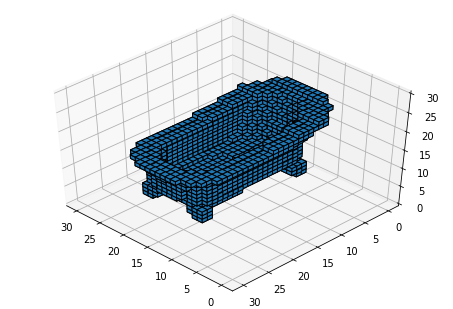

In [2]:
import matplotlib.pyplot as plt
from plots import plot_vox_file
%matplotlib inline


plot_vox_file('./ModelNet10/bathtub/train/bathtub_0005.binvox')

## Evaluate class balance for ModelNet10 and ModelNet40

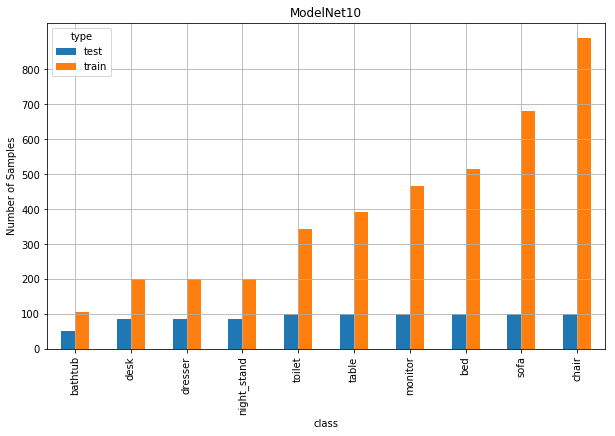

type,test,train
class,,
bathtub,50,106
desk,86,200
dresser,86,200
night_stand,86,200
toilet,100,344
table,100,392
monitor,100,465
bed,100,515
sofa,100,680


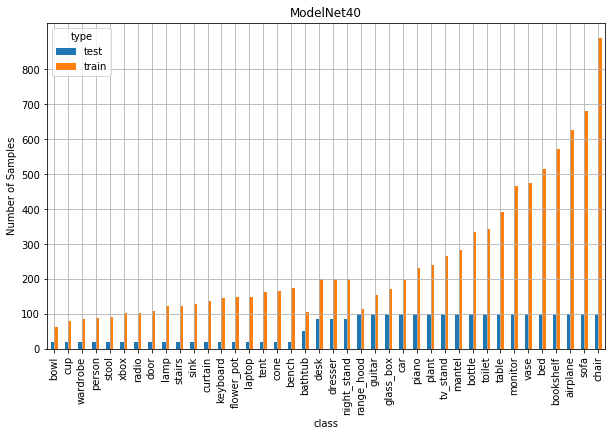

type,test,train
class,,
bowl,20,64
cup,20,79
wardrobe,20,87
person,20,88
stool,20,90
xbox,20,103
radio,20,104
door,20,109
lamp,20,124


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from count_files import (make_file_description_data_frame,
                         plot_unbalanced_classes)

df = make_file_description_data_frame('./ModelNet10/', show_missed=False)
plot_unbalanced_classes(df, 'ModelNet10')

df = make_file_description_data_frame('./ModelNet40/', show_missed=False)
plot_unbalanced_classes(df, 'ModelNet40')

## Get the Data

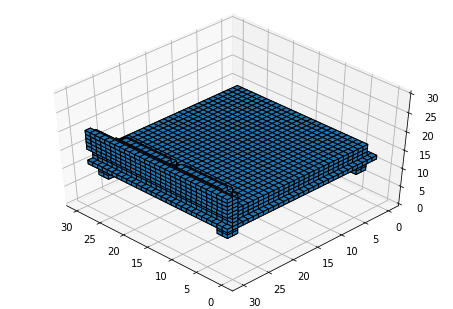

This is a bed.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from data import load_data
from plots import plot_vox

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')

plot_vox(x_train[0].reshape(30, 30, 30)), \
print("This is a {}.".format(target_names[y_train[0]]));

### Class Balance

class to class imbalance is dealt with using upsampling on **only the training data**

train to val imbalance is dealt with using stratified sampling

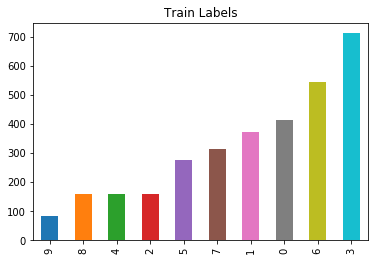

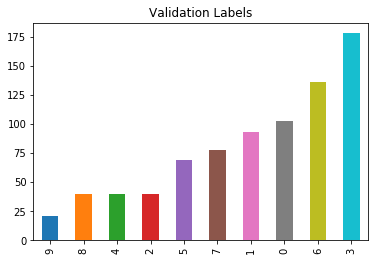

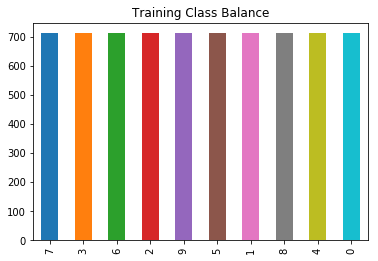

In [1]:
from plots import plot_class_balance
%matplotlib inline

plot_class_balance()

### Build Model
as found in ShapeNets3d paper

In [2]:
import pandas as pd
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from data import load_data
from plots import plot_vox
from utils import upsample_classes, stratified_shuffle

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')
x_train, y_train, x_val, y_val = stratified_shuffle(x_train, y_train, test_size=.1)
x_train, y_train = upsample_classes(x_train, y_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [1]:
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop


model = Sequential()
model.add(Conv3D(48, 6, strides=2,
                 padding='same',
                 activation='relu',
                 input_shape=(30, 30, 30, 1)))
model.add(Conv3D(160, 5, strides=2,
                 padding='same',
                 activation='relu'))
model.add(Conv3D(512, 4, strides=1,
                 padding='same'))
model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10, activation='softmax'))




optimizer = SGD(lr=0.01, momentum=.7, decay=1e-5, nesterov=True)
model.summary()
model.compile(optimizer,
              'categorical_crossentropy',
              metrics=['accuracy'])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 15, 15, 48)    10416     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 8, 8, 160)      960160    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 8, 8, 512)      5243392   
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1200)              314574000 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4000)              4804000   
__________

In [18]:
y_train.shape

(8000, 10)

In [20]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(x_train, y_train,
          epochs=10,
          batch_size=100,
          shuffle=True,
          validation_data=(x_val, y_val),
          callbacks=[TensorBoard(log_dir='./tensor_board.log'), checkpointer])

model.evaluate(x_test, y_test)

Train on 8000 samples, validate on 400 samples
Epoch 1/10
8000/8000 [==============================] - 30s 4ms/step - loss: 1.1087 - acc: 0.6473 - val_loss: 0.3524 - val_acc: 0.8875

Epoch 00001: val_loss improved from inf to 0.35236, saving model to weights.best.hdf5
Epoch 2/10
8000/8000 [==============================] - 20s 3ms/step - loss: 0.2834 - acc: 0.9053 - val_loss: 0.3029 - val_acc: 0.9075

Epoch 00002: val_loss improved from 0.35236 to 0.30291, saving model to weights.best.hdf5
Epoch 3/10
8000/8000 [==============================] - 20s 3ms/step - loss: 0.1873 - acc: 0.9378 - val_loss: 0.3063 - val_acc: 0.9175

Epoch 00003: val_loss did not improve
Epoch 4/10
8000/8000 [==============================] - 20s 3ms/step - loss: 0.1476 - acc: 0.9484 - val_loss: 0.3374 - val_acc: 0.9150

Epoch 00004: val_loss did not improve
Epoch 5/10
8000/8000 [==============================] - 20s 3ms/step - loss: 0.1127 - acc: 0.9573 - val_loss: 0.3250 - val_acc: 0.9175

Epoch 00005: val_loss

[0.5920850709080696, 0.8667400881057269]

In [6]:
model.load_weights('./weights.best.hdf5')

In [7]:
model.evaluate(x_test, y_test)

908/908 [==============================] - 1s 942us/step


[0.4986807402558748, 0.8204845814977973]

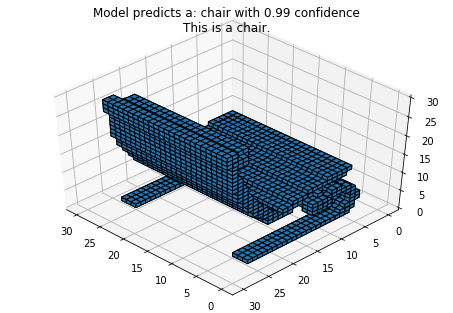

In [28]:
from plots import plot_vox

def plot_model_guess(num):
    truth = target_names[np.argmax(y_test[num])]
    proba = model.predict(x_test[num].reshape(1, 30, 30, 30, 1))
    proba_idx = np.argmax(proba)
    predicted_name = target_names[proba_idx]
    plot_vox(x_test[num].reshape(30, 30, 30),
             title='Model predicts a: {1} with {2:.2f} confidence\nThis is a {0}.'\
              .format(truth, predicted_name, proba[0][proba_idx]))
#     print('this is a {}'.format(target_names[np.argmax(y_test[num])]))
#     proba = model.predict(x_test[num].reshape(1, 30, 30, 30, 1))
#     predicted_name = target_names[np.argmax(proba)]
#     print('the model predicts a {}'.format(predicted_name))

plot_model_guess(350)

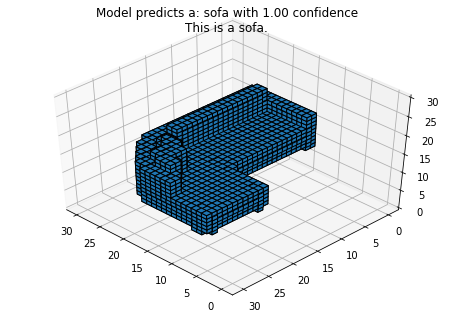

In [29]:
plot_model_guess(0)

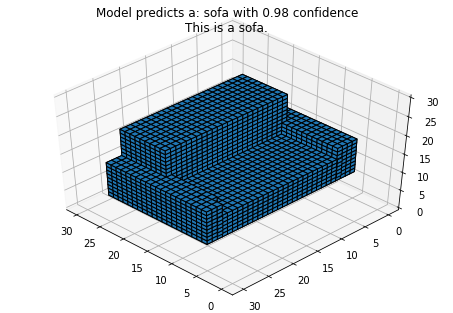

In [30]:
plot_model_guess(80)

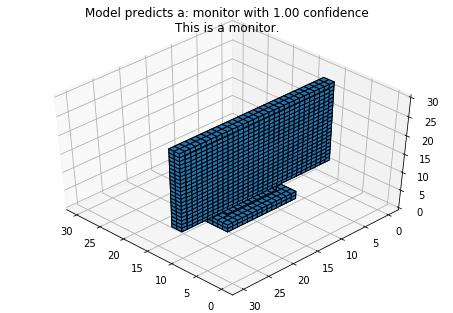

In [31]:
plot_model_guess(160)

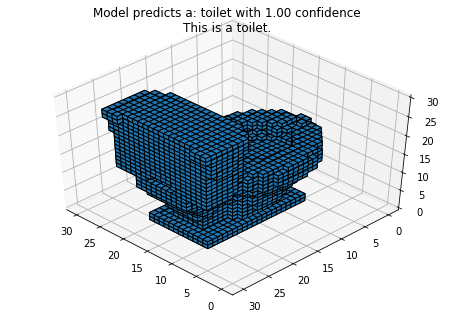

In [32]:
plot_model_guess(240)

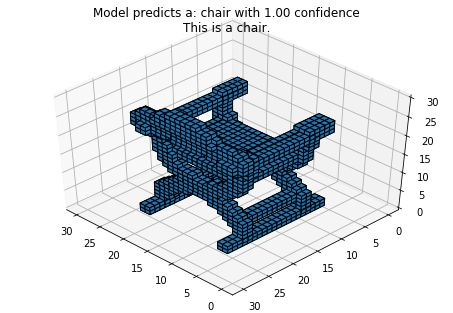

In [33]:
plot_model_guess(320)

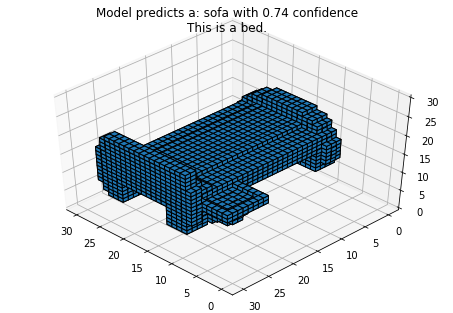

In [34]:
plot_model_guess(400)

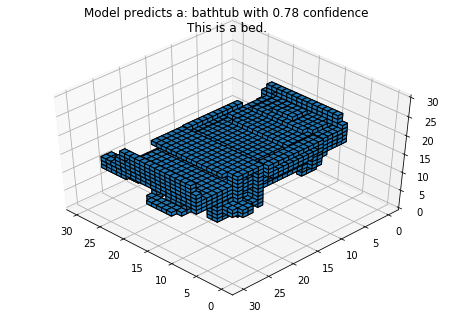

In [35]:
plot_model_guess(480)

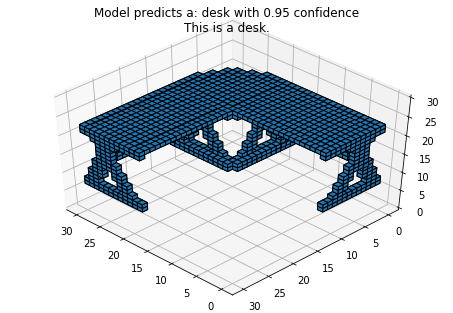

In [36]:
plot_model_guess(560)

WRONG! :-D

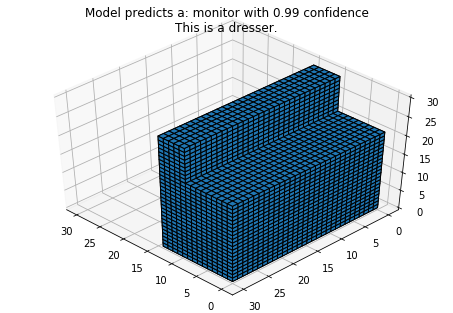

In [37]:
plot_model_guess(640)

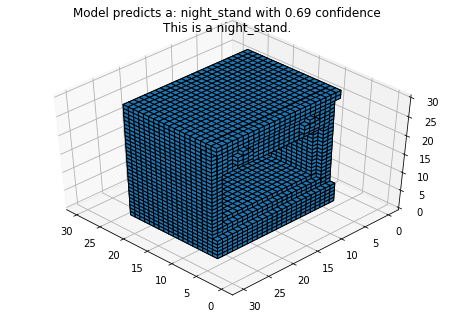

In [38]:
plot_model_guess(720)

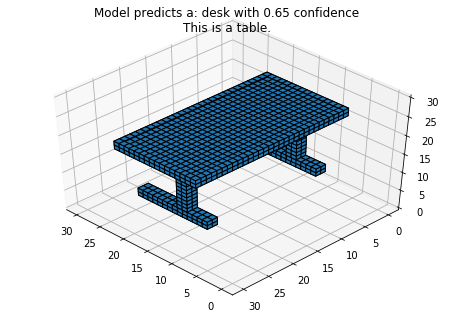

In [39]:
plot_model_guess(800)

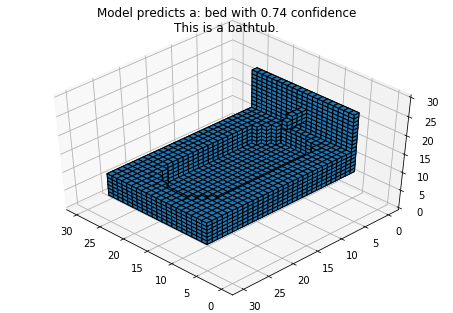

In [41]:
plot_model_guess(880)

# Appendix: